### Installing and importing useful libraries

In [1]:
# Standard libraries
import os
import sys
import math
import random
import datetime

# Numerical computing
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_theme()

#importing optimization techniques
from implementations import *
from helpers import *

### Importing data

In [16]:

base_path = os.path.join("data", "dataset")

# File paths
x_train_path = os.path.join(base_path, "X_train_preprocessed.csv")
y_train_path = os.path.join(base_path, "y_train.csv")

# Load the data
x_train = np.loadtxt(x_train_path, delimiter=',', dtype=float, skiprows=1)
y_train = np.loadtxt(y_train_path, delimiter=',', dtype=float, skiprows=1, usecols=1)

# Convert y_train from {-1, 1} to {0, 1}
y_train = np.where(y_train == -1, 0, y_train)

# Print shapes
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)



x_train shape: (328135, 439)
y_train shape: (328135,)


### Splitting the data between 20 % validation set and 80 % training set

In [3]:
def train_val_split(X, y, val_ratio=0.20, seed=42):
    '''
    Function to randomly split the data in a 20% validation set and a 80% training set
    Args : 
            - X (numpy array) dataset input
            - y (numpy array) dataset output
            - val_ratio (float) validation set percentage, default 20%
            - seed (int) random seed
    Returns : 
            - Input train set, input validation set, output train set, output validation set, train indices, validation indices
    '''
    X = np.asarray(X); y = np.asarray(y)
    n = X.shape[0]
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)

    n_val = int(np.round(n * val_ratio))
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]

    return X[train_idx], X[val_idx], y[train_idx], y[val_idx], train_idx, val_idx


# split dataset in validation and train set
x_train_split, x_val_split, y_train_split, y_val_split, tr_idx, va_idx = train_val_split(x_train, y_train, val_ratio=0.20, seed=42)
print(x_train_split.shape)
print(x_val_split.shape)


(262508, 439)
(65627, 439)


### Hyperparameters definition and metrics

In [4]:
lambdas = [ 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]  # regularization parameters list
gammas = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1] # step-size parameters list
max_iters = [100] # max iters list
k_folds = 5
w_initial = np.zeros(x_train_split.shape[1])


def compute_auc(y_true, y_scores):
    """
    AUC calculation using Mann-Whitney statistics
    Inputs : 
            - y_true : numpy array containing the real {0, 1} values of the dataset
            - y_scores : numpy array containing our predictions
    Output : 
            AUC Area under the ROC curve 
    """
    order = np.argsort(y_scores)
    y_true_sorted = y_true[order]

    n_pos = np.sum(y_true)
    n_neg = len(y_true) - n_pos

    # rank positions 
    rank_positions = np.arange(1, len(y_true_sorted) + 1)
    rank_sum = np.sum(rank_positions[y_true_sorted == 1])

    # AUC using Mann–Whitney
    auc = (rank_sum - n_pos*(n_pos+1)/2) / (n_pos * n_neg)
    return auc

def compute_accuracy(y_true, y_scores) : 
    """
    Accuracy computation
    Inputs : 
            - y_true : numpy array containing the real {0, 1} values of the dataset
            - y_scores : numpy array containing our predictions
    Output : 
            Accuracy = correct predictions / total predictions %

    """
    correct_pred = (y_true == y_scores)
    accuracy = np.mean(correct_pred) * 100
    return accuracy

def compute_F1(y_true, y_pred):
    # Convert to boolean arrays
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)

    # True positives, false positives, false negatives
    tp = np.sum(y_pred & y_true)
    fp = np.sum(y_pred & ~y_true)
    fn = np.sum(~y_pred & y_true)

    # F1 score
    return 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) > 0 else 0
    


### Functions to balance data

In [5]:
# BALANCING DATA BY UNDERSAMPLING

def undersample(x_train_filtered, y_train, seed=21):
    """
    Create a balanced subset of the training data by undersampling the majority class.
    Args: 
            - x_train_filtered : np.ndarray
                Feature matrix of shape (n_samples, n_features).
            - y_train : np.ndarray
                Array of class labels of shape (n_samples,).
            - seed : int, optional
                Random seed 

    Returns
    
            - x_bal : np.ndarray
                Balanced feature matrix of shape (2 * n_minority, n_features).
            - y_bal : np.ndarray
                Corresponding balanced labels.

    """
    rng= np.random.default_rng(seed)
    # Define majority class and minority class
    unique_classes, counts = np.unique(y_train, return_counts=True)
    maj_class = unique_classes[np.argmax(counts)]
    min_class = unique_classes[np.argmin(counts)]

    # Boolean masks
    maj_mask = (y_train == maj_class)
    min_mask = (y_train == min_class)

    # Indices per class
    maj_idx = np.nonzero(maj_mask)[0]
    min_idx = np.nonzero(min_mask)[0]

    # Target size = size of minority (undersample majority)
    n = len(min_idx)

    # Sample without replacement
    sampled_maj = rng.choice(maj_idx, size=n, replace=False)
    sampled_min = rng.choice(min_idx, size=n, replace=False)

    # Combine and shuffle
    balanced_idx = np.concatenate([sampled_maj, sampled_min])
    rng.shuffle(balanced_idx)

    # Slice arrays
    x_bal = x_train_filtered[balanced_idx]
    y_bal = y_train[balanced_idx]
    return x_bal, y_bal

#BALANCING DATA BY OVERSAMPLING
def oversample(x_train, y_train, seed= 21) :
    "Balancing data oversampling the minority class"
    """
    Args: 
            - x_train (numpy array) input train dataset
            - y_train (numpy array) output train dataset
            - seed (int) randomization seed
    Returns: 
            - x_bal_shuf (numpy array) balanced input dataset
            - y_bal_shuf (numpy array) balanced output dataset
           
    """
    rng= np.random.default_rng(seed)
    # Define majority class and minority class
    unique_classes, counts = np.unique(y_train, return_counts=True)
    maj_class = unique_classes[np.argmax(counts)]
    min_class = unique_classes[np.argmin(counts)]

    # Boolean masks
    maj_mask = (y_train == maj_class)
    min_mask = (y_train == min_class)

    # Indices per class
    maj_idx = np.nonzero(maj_mask)[0]
    min_idx = np.nonzero(min_mask)[0]

    # Target size = size of majority (oversample majority)
    n = len(maj_idx)

    # Sample and randomize
    sampled_min = rng.choice(min_idx, size=n, replace=True)

    # Create balanced dataset
    balanced_idx = np.concatenate([maj_idx, sampled_min])
    rng.shuffle(balanced_idx)

    x_bal = x_train[balanced_idx]
    y_bal = y_train[balanced_idx]
    

    return x_bal , y_bal


### K-fold cross validation with oversampling and undersampling dataset

In [6]:
import implementations
import importlib
importlib.reload(implementations)
from implementations import *

 

def build_k_indices(N, k_fold, seed=21): 
    """build k indices for k-fold. 
        Args: N: num of samples 
              k_fold: K in K-fold, i.e. the fold num 
              seed: the random seed 
        Returns: 
              A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold 
    """
    num_row = N 
    interval = int(num_row / k_fold) 
    np.random.seed(seed) 
    indices = np.random.permutation(num_row) 
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)] 
    return np.array(k_indices)
     

def k_fold_cross_validation(y_train, x_train, lambdas, gammas, max_iters, k_fold, methods,w_initial, seed, undersampling = False, oversampling = True) :
    """
    Function to perform a k-cross validation between different models - L2-regularized logistic regression with gradient descent, 
    least squares, L2-regularized logistic regression with Adam, ridge regression, Linear regression with SGD and GD - in order to find the best one to make predictions on our dataset. We use AUC 
    as metric to rank the models

    Args : 
            - y_train (numpy array) output train dataset
            - x_train (numpy array) input train dataset
            - lambdas (list)  hyperparameters regularization term
            - gammas (list) step-sizes
            - max_iters (list) maximum iterations to perform in the optimization algorithm 
            - k_fold (int) number of folds to per perform k-cross
            - methods (list) methods to apply to reach the optimum parameters w_opt
            - seed (int) random seed
            - undersampling (boolean) k-cross will perform data balancing by undersampling the majority class or not 
            - oversampling (boolena)  k-cross will perform data balancing by oversampling the minority class or not 
    Returns:
            - results (list of dictionaries) contains for each method the best lambda, gamma, max_iter and their corresponding train loss, test loss , AUC, accuracy, predictions and optimum weights 
                        vector
            - best_overall (dictionary) contains the best method wrt AUC and its corresponding lambda, gamma, max_iter, train loss, test loss, AUC, accuracy, predictions, optimum weights vector



    """
    k_indices = build_k_indices(len(y_train), k_fold, seed)

    # Precompute train/test sets for each fold 
    folds_data = []
    for k in range(k_fold):
        test_mask = np.isin(np.arange(len(y_train)), k_indices[k, :])
        y_test_k = y_train[test_mask]
        x_test_k = x_train[test_mask]
        y_train_k = y_train[~test_mask]
        x_train_k = x_train[~test_mask]

       # balance data
    if undersampling :
        # balancing dataset by undersampling the majority class
        x_train_k , y_train_k = undersample(x_train_k, y_train_k)
    if oversampling :
        # balancing dataset by oversampling the minority class
        x_train_k , y_train_k = oversample(x_train_k, y_train_k, seed)

    folds_data.append((x_train_k, y_train_k, x_test_k, y_test_k))

    # Dictionary to contain the best method with the best parameters and its metrics
    best_overall = {"method": "", "lambda_": 0, "gamma": 0, "max_iter": 0, "train_loss": 0, "test_loss": 0, "AUC": 0,"F1_score":0,  "accuracy": 0}
    results =[] # to keep the best results per method


    # Scroll the hyperparamters to find the best ones per method and overall
    for method in methods : 
        best_per_method =  {"method": "", "lambda_": 0, "gamma": 0, "max_iter": 0, "train_loss": 0, "test_loss": 0, "AUC": 0,"F1_score":0, "accuracy": 0} 
        for lam in lambdas : # scroll lambdas
            for gam in gammas : #scroll gammas
                for max_it in max_iters : #scroll iters ----> model defined at this point
                    loss_tr = []
                    loss_te =[]
                    AUC=  []
                    F1 = []
                    accuracies = []
                    
                    for (x_train_k, y_train_k, x_test_k, y_test_k) in folds_data:

                        #train the model
                        if method == "reg_logistic_regression" :
                            w_opt, loss = reg_logistic_regression_2(y_train_k, x_train_k,lam, w_initial, max_it, gam)
                        elif method == "least_squares" :
                            w_opt, loss = least_squares(y_train_k, x_train_k)
                        elif method == "adam_reg_logistic_regression":
                            w_opt, loss = reg_logistic_regression_adam(y_train_k, x_train_k, lam, w_initial, max_it, 0.9, 0.999, gam, 700 )
                        elif method == "ridge_regression" :
                            w_opt, loss = ridge_regression(y_train_k, x_train_k, lam)
                        elif method=="mean_squared_error_gd":
                            w_opt, loss = mean_squared_error_gd_2(y_train_k, x_train_k,  w_initial, max_it, gam)
                        elif method=="mean_squared_error_sgd":
                            w_opt, loss = mean_squared_error_sgd_2(y_train_k, x_train_k, w_initial, max_it, gam)

                        #compute metrics 
                        loss_tr.append(loss) 
                        if method in ["adam_reg_logistic_regression", "reg_logistic_regression"]:
                            loss_te.append(compute_logistic_loss(y_test_k, x_test_k, w_opt)) #without penalizing term 
                        else:
                            loss_te.append(compute_mse_loss(y_test_k, x_test_k, w_opt))
                        
                        if method in ["logistic_regression", "reg_logistic_regression"]:
                            y_score = sigmoid(x_test_k @ w_opt) 
                        else:
                            y_score = x_test_k @ w_opt 
                        y_pred = np.where(y_score >=0.5, 1, 0)
                        AUC.append(compute_auc(y_test_k, y_score))
                        accuracies.append(compute_accuracy(y_test_k, y_pred))
                        F1.append(compute_F1(y_test_k, y_pred))

                    # update
                    mean_AUC = np.mean(AUC)    
                    if mean_AUC > best_per_method["AUC"]:
                        best_per_method.update({"method": method, "gamma": gam, "lambda_": lam, "max_iter": max_it, "train_loss": np.mean(loss_tr), "test_loss": np.mean(loss_te), "AUC": np.mean(AUC), "F1_score": np.mean(F1), "accuracy": np.mean(accuracies)})

                    if mean_AUC > best_overall["AUC"]:
                        best_overall.update({"method": method, "gamma": gam, "lambda_": lam, "max_iter": max_it, "train_loss": np.mean(loss_tr), "test_loss": np.mean(loss_te), "AUC": np.mean(AUC), "F1_score": np.mean(F1),"accuracy": np.mean(accuracies)})

        results.append(best_per_method)
        print(f"For method {method}, best λ={best_per_method['lambda_']}, γ={best_per_method['gamma']}, max_iter={best_per_method['max_iter']}, accuracy ={best_per_method['accuracy']}, AUC = {best_per_method['AUC']}, F1 ={best_per_method['F1_score']}")


    
    print(f"The best method is {best_overall['method']}, with best λ={best_overall['lambda_']}, γ={best_overall['gamma']}, max_iter={best_overall['max_iter']}, accuracy ={best_overall['accuracy']}, AUC = {best_overall['AUC']}, F1 ={best_overall['F1_score']}")



    return best_overall, results 

        
methods=["reg_logistic_regression", "least_squares", "adam_reg_logistic_regression", "ridge_regression", "mean_squared_error_gd", "mean_squared_error_sgd" ]










In [15]:
# Validate with k-cross validation with oversampling and k_folds folds 
best_method_2, results_2 = k_fold_cross_validation(y_train_split, x_train_split, lambdas, gammas, max_iters , k_folds, methods,w_initial, seed = 21, undersampling= False, oversampling=True)

For method reg_logistic_regression, best λ=0.001, γ=0.1, max_iter=100, accuracy =73.38907830327042, AUC = 0.7602302773990631, F1 =0.3493083694285315
For method least_squares, best λ=0.0001, γ=0.0001, max_iter=100, accuracy =75.60427420430086, AUC = 0.7788621417504481, F1 =0.373936846221527
For method adam_reg_logistic_regression, best λ=0.0001, γ=0.1, max_iter=100, accuracy =79.77943277270909, AUC = 0.7584437693668824, F1 =0.38819732595666206
For method ridge_regression, best λ=0.001, γ=0.0001, max_iter=100, accuracy =75.5718938686882, AUC = 0.7796348988629043, F1 =0.37417654808959155
For method mean_squared_error_gd, best λ=0.0001, γ=0.01, max_iter=100, accuracy =70.94341060170282, AUC = 0.7437298588903538, F1 =0.32711393410083367
For method mean_squared_error_sgd, best λ=0.01, γ=0.01, max_iter=100, accuracy =60.67313003561837, AUC = 0.7235276520671189, F1 =0.2833639929193711
The best method is ridge_regression, with best λ=0.001, γ=0.0001, max_iter=100, accuracy =75.5718938686882, AU

In [7]:
# Validate with k-cross validation with undersampling and k_folds folds
best_method_1, results_1 = k_fold_cross_validation(y_train_split, x_train_split, lambdas, gammas, max_iters , k_folds, methods,w_initial, seed = 21, undersampling= True, oversampling=False)

For method reg_logistic_regression, best λ=0.0001, γ=0.5, max_iter=100, accuracy =55.829412773090034, AUC = 0.8445980952690738, F1 =0.2787833551035641
For method least_squares, best λ=0.0001, γ=0.0001, max_iter=100, accuracy =75.53570408182702, AUC = 0.8537007601319665, F1 =0.37352453419178616
For method adam_reg_logistic_regression, best λ=0.001, γ=0.01, max_iter=100, accuracy =84.01744728671835, AUC = 0.8501400169208211, F1 =0.40544179125628854
For method ridge_regression, best λ=0.001, γ=0.0001, max_iter=100, accuracy =75.56237024056685, AUC = 0.8543307592392269, F1 =0.37414634146341463
For method mean_squared_error_gd, best λ=0.0001, γ=0.01, max_iter=100, accuracy =70.88436410735034, AUC = 0.8123114058679619, F1 =0.3264298933638847
For method mean_squared_error_sgd, best λ=0.01, γ=0.01, max_iter=100, accuracy =34.24887145006762, AUC = 0.7769171814709195, F1 =0.2103577637478269
The best method is ridge_regression, with best λ=0.001, γ=0.0001, max_iter=100, accuracy =75.5623702405668

In [ ]:
# Validate on the best two methods found before 
methods = ["adam_reg_logistic_regression", "ridge_regression"]
lambdas = [1e-5,  1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]  # regularization parameters list
gammas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1e1, 1e2] # step-size parameters list
max_iters =[100, 1000, 2000, 5000]
best_method_3, results_3 = k_fold_cross_validation(y_train_split, x_train_split, lambdas, gammas, max_iters , k_folds, methods, w_initial, seed = 21, undersampling= True, oversampling=False)

For method adam_reg_logistic_regression, best λ=0.001, γ=0.01, max_iter=5000, accuracy =81.96605778937544, AUC = 0.8540090338971527, F1 =0.4071383844708829
For method ridge_regression, best λ=0.001, γ=1e-05, max_iter=100, accuracy =75.56237024056685, AUC = 0.8543307592392269, F1 =0.37414634146341463
The best method is ridge_regression, with best λ=0.001, γ=1e-05, max_iter=100, accuracy =75.56237024056685, AUC = 0.8543307592392269, F1 =0.37414634146341463


### Validation on our validation sample

In [14]:
# Define validation function
def validation(w_opt, x_val, y_val, method, threshold): 
    if method in ["reg_logistic_regression", "adam_reg_logistic_regression"] :
        
        y_score = sigmoid(x_val @ w_opt) 
    else:
        y_score = x_val @ w_opt
    y_pred = np.where(y_score >=threshold, 1, 0) 
    AUC = compute_auc(y_val, y_score)
    accuracy = compute_accuracy(y_val, y_pred)
    F1 = compute_F1(y_val, y_pred)

    return AUC, accuracy, F1

# Retrain optimal models on the whole validation dataset

# Ridge regression
method = "ridge_regression"
w_opt, _ = ridge_regression(y_val_split, x_val_split, 0.001) # use best lambda found through k-cross validation
# find best threshold to make predictions
if method in ["reg_logistic_regression", "adam_reg_logistic_regression"] :
        
        y_score = sigmoid(x_val_split @ w_opt) 
else:
        y_score = x_val_split @ w_opt 

thresholds = np.linspace(0, 1, 101)
best_F1 = 0
best_thresh = 0.5
for t in thresholds:
    y_pred = (y_score >= t).astype(int)
    F1 = compute_F1(y_val_split, y_pred)
    if F1 > best_F1:
        best_F1 = F1
        best_thresh = t
print(f"Best threshold = {best_thresh:.2f}, F1 = {best_F1:.3f}")
# validate
AUC, accuracy, F1 = validation(w_opt, x_val_split, y_val_split,method,  best_thresh)
print(f"the method ridge regression has an accuracy = {accuracy}, AUC = {AUC}, F1 score = {F1} on our validation set")

# Adam 
method = "adam_reg_logistic_regression"
w_opt, _ = reg_logistic_regression_adam(y_val_split, x_val_split, 0.001, w_initial, 5000, 0.9, 0.999, 0.01, 700 ) # use best hyperparameters found through k-cross validation
#find best threshold to make predictions
if method in ["reg_logistic_regression", "adam_reg_logistic_regression"] :
        
        y_score = sigmoid(x_val_split @ w_opt) 
else:
        y_score = x_val_split @ w_opt 

thresholds = np.linspace(0, 1, 101)
best_F1 = 0
best_thresh = 0.5
for t in thresholds:
    y_pred = (y_score >= t).astype(int)
    F1 = compute_F1(y_val_split, y_pred)
    if F1 > best_F1:
        best_F1 = F1
        best_thresh = t
print(f"Best threshold = {best_thresh:.2f}, F1 = {best_F1:.3f}")
# validate
AUC, accuracy, F1 = validation(w_opt, x_val_split, y_val_split, method, best_thresh) 
print(f"the method adam_reg_logistic_regression has an accuracy = {accuracy}, AUC = {AUC}, F1 score = {F1} on our validation set")

Best threshold = 0.20, F1 = 0.424
the method ridge regression has an accuracy = 85.9874746674387, AUC = 0.8533457745231879, F1 score = 0.4238817190828217 on our validation set
Best threshold = 0.18, F1 = 0.384
the method adam_reg_logistic_regression has an accuracy = 84.77913054078353, AUC = 0.8320293259996259, F1 score = 0.38366138088480284 on our validation set


### Visualization plot

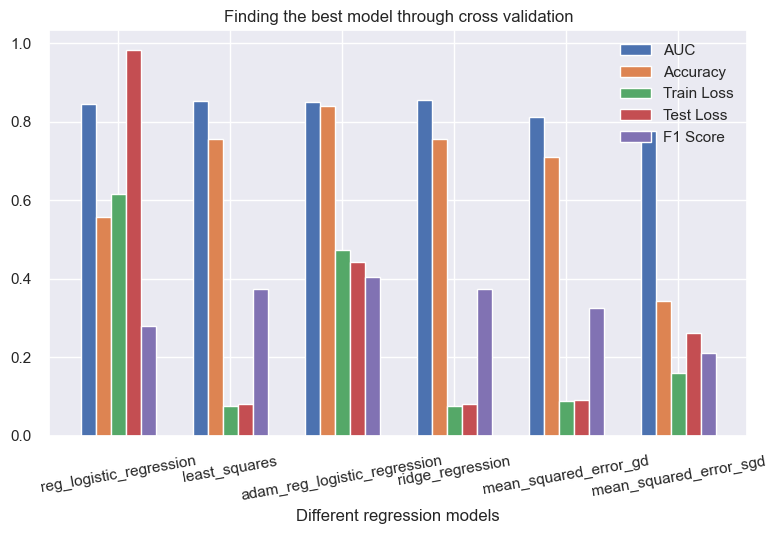

In [ ]:
AUC = []
accuracy = []
loss_tr = []
loss_te = []
F1 = []

for result in results_1:
    AUC.append(result['AUC'])
    accuracy.append(result['accuracy']/100)
    loss_tr.append(result['train_loss'])
    loss_te.append(result['test_loss'])
    F1.append(result["F1_score"])

num_bars = len(results_1)
w = 0.2  
pos = np.arange(num_bars) * 1.5  

plt.bar(pos - 2*w, AUC, width=w, label='AUC')
plt.bar(pos - w, accuracy, width=w, label='Accuracy')
plt.bar(pos, loss_tr, width=w, label='Train Loss')
plt.bar(pos + w, loss_te, width=w, label='Test Loss')
plt.bar(pos + 2*w, F1, width=w, label='F1 Score')  

plt.xticks(pos, methods, rotation=10)
plt.xlabel('Different regression models')
plt.title('Finding the best model through cross validation')
plt.legend()
plt.tight_layout()
plt.show()


### Precision-recall curve and F1 vs threshold curve

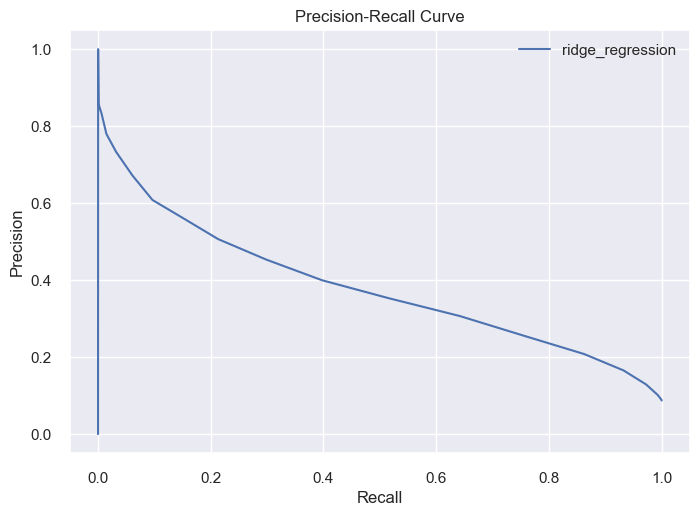

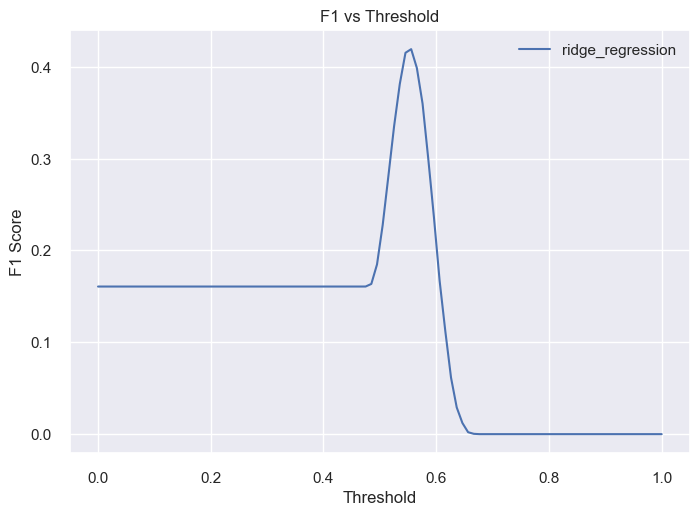

In [11]:
def plot_precision_recall(y_true, y_score, method):
    thresholds = np.linspace(0, 1, 100)
    precision, recall = [], []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        p = tp / (tp + fp + 1e-9)
        r = tp / (tp + fn + 1e-9)
        precision.append(p)
        recall.append(r)

    plt.plot(recall, precision, label=f"{method}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_f1_vs_threshold(y_true, y_score, method):
    thresholds = np.linspace(0, 1, 100)
    F1s = [compute_F1(y_true, (y_score >= t).astype(int)) for t in thresholds]
    plt.plot(thresholds, F1s, label=f"{method}")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("F1 vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot precision-recall curve
w_opt, _ = ridge_regression(y_val_split, x_val_split, 0.001) # use best lambda found through k-cross validation
y_score = sigmoid(x_val_split @ w_opt) 
plot_precision_recall(y_val_split, y_score, "ridge_regression")

# Plot F1 score vs threshold
plot_f1_vs_threshold(y_val_split, y_score, "ridge_regression")


### Test the model and generate the predictions

In [14]:
import csv
import os
import numpy as np
from helpers import load_csv_data, create_csv_submission
from implementations import (
    reg_logistic_regression,
    reg_logistic_regression_adam,
    least_squares,
    ridge_regression,
)

def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))

# ====== CONFIG: update these paths to your actual files ======
DATA_DIR   = "/Users/neilabenlamri/PycharmProjects/project-1-girl_power/data"
IMPUTE_NPZ = f"{DATA_DIR}/dataset/impute_vals.npz"
SCALER_NPZ = f"{DATA_DIR}/dataset/scaler_zscore.npz"
PCA_NPZ = f"{DATA_DIR}/dataset/pca_model_72.npz"

# ⚠️ Set to the real test csv path (often it's .../data/x_test.csv, not .../dataset/x_test.csv)
XTEST_CSV  = f"{DATA_DIR}/dataset/x_test.csv"

XTRAIN_PCA = f"{DATA_DIR}/dataset/pca_train_projection.csv"
YTRAIN_CSV = f"{DATA_DIR}/dataset/y_train.csv"

# ---------- helpers ----------
def load_feature_names_from_imputer(npz_path):
    d = np.load(npz_path, allow_pickle=True)
    feature_names = [str(x) for x in d["feature_names"]]
    fillers = d["fillers"].astype(float)
    return feature_names, fillers

def load_headers(csv_path):
    with open(csv_path, "r") as f:
        reader = csv.reader(f)
        header = next(reader)
    return header  # includes "Id" as first col

def load_matrix(csv_path):
    return np.genfromtxt(csv_path, delimiter=",", skip_header=1)

def apply_imputation(X, fillers):
    X = X.copy()
    for j in range(X.shape[1]):
        m = np.isnan(X[:, j])
        if m.any():
            X[m, j] = fillers[j]
    return X

def load_scaler(npz_path):
    d = np.load(npz_path, allow_pickle=True)
    out = {"mean": d["mean"].astype(float), "std": d["std"].astype(float)}
    # prefer using scaler's own feature list if present
    if "feature_names" in d.files:
        out["feature_names"] = [str(x) for x in d["feature_names"]]
    return out

def transform_standardizer(matrix, scaler):
    return (matrix - scaler["mean"]) / scaler["std"]

def pca_transform_npz(standardized_data, pca_npz_path):
    X = np.asarray(standardized_data, dtype=float)
    d = np.load(pca_npz_path, allow_pickle=True)
    components = d["components"]                 # (p x k)
    n_features = int(d["n_features"][0])        # p
    assert X.shape[1] == n_features, f"PCA expects {n_features} features, got {X.shape[1]}"
    return X @ components

# ---------- build Z_test exactly like train ----------
def build_Z_test_from_raw():
    assert os.path.exists(XTEST_CSV), f"Missing test csv: {XTEST_CSV}"
    X_full = load_matrix(XTEST_CSV)
    ids_test = X_full[:, 0].astype(int)
    X_full = X_full[:, 1:]  # drop Id
    header_no_id = load_headers(XTEST_CSV)[1:]

    feat_imp, fillers = load_feature_names_from_imputer(IMPUTE_NPZ)
    scaler = load_scaler(SCALER_NPZ)
    pca_npz = np.load(PCA_NPZ, allow_pickle=True)
    p_exp = int(pca_npz["n_features"][0])              # features PCA expects
    p_scaler = scaler["mean"].shape[0]                 # features scaler expects
    assert p_exp == p_scaler, f"PCA expects {p_exp} features but scaler has {p_scaler}"

    # Choose the authoritative feature list: scaler's if available; else imputer's
    if "feature_names" in scaler:
        wanted_names = scaler["feature_names"]
    else:
        wanted_names = feat_imp
    # sanity
    assert len(wanted_names) == p_scaler, f"Feature-list len {len(wanted_names)} != scaler len {p_scaler}"

    # Build index mapping and slice columns in the same order
    name2idx = {name: i for i, name in enumerate(header_no_id)}
    try:
        cols = [name2idx[n] for n in wanted_names]
    except KeyError as e:
        missing = [n for n in wanted_names if n not in name2idx]
        raise KeyError(f"Test CSV missing expected columns: {missing[:5]} ...")

    X_sel = X_full[:, cols]

    # Impute, Standardize, PCA
    X_imp = apply_imputation(X_sel, fillers[:X_sel.shape[1]])
    X_std = transform_standardizer(X_imp, scaler)
    assert X_std.shape[1] == p_scaler, f"Std shape {X_std.shape} vs scaler {p_scaler}"
    Z_test = pca_transform_npz(X_std, PCA_NPZ)
    return ids_test, Z_test

# ---------- refit the best model on FULL train ----------
def refit_best_on_full(best_method):
    method = best_method["method"]
    lam    = best_method["lambda_"]
    gam    = best_method["gamma"]
    max_it = best_method["max_iter"]

    Z_train = np.loadtxt(XTRAIN_PCA, delimiter=",", dtype=float, skiprows=1)
    y_train = np.loadtxt(YTRAIN_CSV, delimiter=",", dtype=float, skiprows=1, usecols=1)
    y_tr = np.where(y_train == -1, 0, y_train)  # keep same encoding as in CV

    if method == "reg_logistic_regression":
        w_opt, _ = reg_logistic_regression(y_tr, Z_train, lam, np.zeros(Z_train.shape[1]), max_it, gam)
    elif method == "adam_reg_logistic_regression":
        w_opt, _ = reg_logistic_regression_adam(y_tr, Z_train, lam, np.zeros(Z_train.shape[1]),
                                                max_it, 0.9, 0.999, gam, 700)
    elif method == "least_squares":
        w_opt, _ = least_squares(y_tr, Z_train)
    elif method == "ridge_regression":
        w_opt, _ = ridge_regression(y_tr, Z_train, lam)
    else:
        raise ValueError(f"Unknown method: {method}")

    return w_opt, method

# ---------- predict + write CSV ----------
def predict_labels(X, w, method):
    if method in ["reg_logistic_regression", "adam_reg_logistic_regression"]:
        scores = sigmoid(X @ w)
        y01 = (scores >= 0.5).astype(int)
    else:
        scores = X @ w
        y01 = (scores >= 0.5).astype(int)
    y = y01.copy()
    y[y == 0] = -1
    return y

def make_submission(best_method, out_path="submission.csv"):
    test_ids, Z_test = build_Z_test_from_raw()
    w_best, method = refit_best_on_full(best_method)
    y_pred = predict_labels(Z_test, w_best, method)
    create_csv_submission(test_ids, y_pred, out_path)
    print(f"[OK] Saved {out_path} with {len(y_pred)} rows — method={method}, λ={best_method['lambda_']}  → {out_path}")

# === Run it ===
make_submission(best_method, out_path="submission.csv")


AssertionError: Feature-list len 78 != scaler len 72